# Difference between Human and Mouse Dataset: Permutation test

This notebook follows the notebook on confidence bands of persistent silhouette. After obtaining different silhouettes curve for human and mouses, we want to run two sample permutation test, to assess the significance of the observed topological differences.

# Preprocessing

In [1]:
import tmd
from tmd.view import plot
from tmd.view import view

import gtda
from gtda.diagrams import Silhouette, PersistenceLandscape

import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [3]:
import functions as fcts

### Loading and checking the data

In [4]:
data_folder = "../Data/ExamplesL23PC"
folders_to_treat = ['Human','Mouse']

In [5]:
grouped_neurons = fcts.check_and_load_neurons(data_folder, folders_to_treat)

Folder: Human
Neurons loaded: 186
Total files in folder: 187
.asc files in folder: 186
Failed to load: 0 files
Unloaded files: []

Folder: Mouse
Neurons loaded: 38
Total files in folder: 39
.asc files in folder: 38
Failed to load: 0 files
Unloaded files: []



### Computing entropy, persistence landscape and silhouette

<div class="alert alert-block alert-success">
    
In the following box, we can modify multiple parameters:
- `neuron_part`: can either be *basal_dendrite*, *apical_dendrite*, *axon* or *dendrite*. It depends on which part of the neuron with want to take into account
- `distance_type`: could either be *radial_distances* or *path_distances*

</div>

In [6]:
region = "basal_dendrite"
distance = "path_distances"

In [7]:
#Preparing the ph diagrams

neurons_mouse = grouped_neurons["Mouse"]
ph_diagrams_mouse = fcts.compute_diagrams(
    neurons_mouse, 
    group_name = "Mouse", 
    neuron_part = region,
    distance_type = distance
)
formatted_mouse = fcts.format_diagrams_for_gtda(ph_diagrams_mouse)
padded_mouse= fcts.pad_diagrams(formatted_mouse)

neurons_human = grouped_neurons["Human"]
ph_diagrams_human = fcts.compute_diagrams(
    neurons_human, 
    group_name = "Human", 
    neuron_part = region,
    distance_type = distance
)
formatted_human = fcts.format_diagrams_for_gtda(ph_diagrams_human)
padded_human = fcts.pad_diagrams(formatted_human)

[Mouse] Computed 38 persistence diagrams for basal_dendrites.
[Human] Computed 186 persistence diagrams for basal_dendrites.


In [8]:
#Entropy life curves
bins = np.linspace(0, 1000, 30)

life_entropy_mouse = []
for i in range(len(ph_diagrams_mouse)):
    entropy_mouse = tmd.vectorizations.life_entropy_curve(ph_diagrams_mouse[i], bins)[0]
    life_entropy_mouse.append(entropy_mouse)
life_entropy_mouse = np.array(life_entropy_mouse)

life_entropy_human = []
for i in range(len(ph_diagrams_human)):
    entropy_human = tmd.vectorizations.life_entropy_curve(ph_diagrams_human[i], bins)[0]
    life_entropy_human.append(entropy_human)
life_entropy_human = np.array(life_entropy_human)

In [9]:
#Landscapes
lan = PersistenceLandscape()
landscape_mouse = lan.fit_transform(padded_mouse)

lan = PersistenceLandscape()
landscape_human = lan.fit_transform(padded_human)

In [10]:
#Silhouettes
sil = Silhouette()
silhouettes_mouse = sil.fit_transform(padded_mouse)

sil = Silhouette()
silhouettes_human = sil.fit_transform(padded_human)

# Entropy Permutation test

## Between the two groups

To statistically assess the difference in topological morphology between human and mouse neurons, we perform a permutation test comparing the mean persistence silhouette curves derived from the apical dendrites of each group. The test use the L∞ norm to quantify the maximum pointwise difference between group means.

In more simple terms, this is what we do:
- We observe a real difference.
- Then we simulate what differences you'd expect if the labels were meaningless.
- We count how many of those random differences are at least as big as the real one.
- The **p-value** tells you how surprising your observed difference is under the null.

### Statistics

In [11]:
p_value_ent, observed_stat_ent, null_dist_ent = fcts.permutation_test(
    life_entropy_human,
    life_entropy_mouse,
    n_permutations=1000,
    metric='linf'  # or 'l2'
)

print(f"Observed test statistic (Entropy): {observed_stat_ent:.4f}")
print(f"P-value (Entropy): {p_value_ent:.4f}")

Observed test statistic (Entropy): 1.5581
P-value (Entropy): 0.0010


### Plots

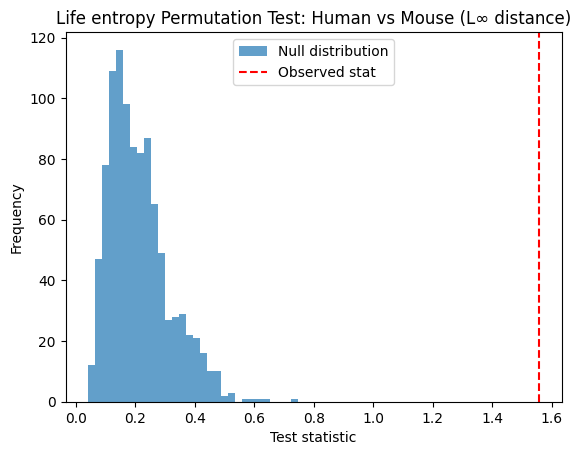

In [12]:
plt.hist(null_dist_ent, bins=30, alpha=0.7, label='Null distribution')
plt.axvline(observed_stat_ent, color='red', linestyle='--', label='Observed stat')
plt.title('Life entropy Permutation Test: Human vs Mouse (L∞ distance)')
plt.xlabel('Test statistic')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/entropy_permutation_test_inter'+region+'.png')

plt.show()

This result is further illustrated in the plot, which shows the null distribution of test statistics obtained from the 1000 permutations. The red dashed line represents the observed test statistic computed from the actual group labels. Its clear separation from the bulk of the null distribution confirms that the difference in topological signatures between human and mouse apical dendrites is not attributable to random variation. The shape of the null distribution also highlights the sensitivity of the test: values as extreme as the observed one were almost never reached under random labelings, providing strong empirical support for the statistical significance of the difference.

## Within the groups

A permutation test *within the group* tells us what kind of differences are normal within a group that should be homogeneous.

$\to$ *Is the inter-species difference bigger than any difference we’d expect within a single species?*


### Mouse

In [13]:
mouse_stats_ent =fcts.within_group_permutation_test(life_entropy_mouse, n_trials=100)

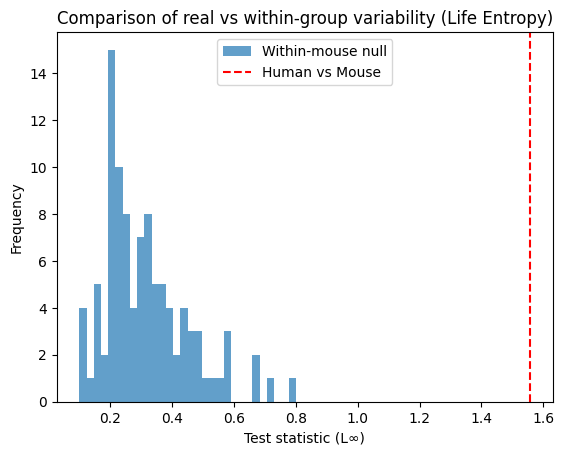

In [14]:
plt.hist(mouse_stats_ent, bins=30, alpha=0.7, label='Within-mouse null')
plt.axvline(observed_stat_ent, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Life Entropy)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/entropy_permutation_test_mouse'+region+'.png')

plt.show()

### Human

In [15]:
human_stats_ent =fcts.within_group_permutation_test(life_entropy_human, n_trials=100)

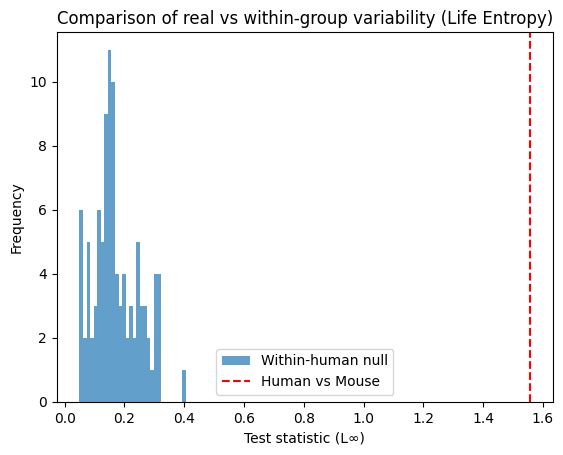

In [16]:
plt.hist(human_stats_ent, bins=30, alpha=0.7, label='Within-human null')
plt.axvline(observed_stat_ent, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Life Entropy)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/entropy_permutation_test_human'+region+'.png')
plt.show()

# Landscape Permutation test

## Between the two groups

To statistically assess the difference in topological morphology between human and mouse neurons, we perform a permutation test comparing the mean persistence lanscape curves derived from the apical dendrites of each group. The test use the L∞ norm to quantify the maximum pointwise difference between group means.

In more simple terms, this is what we do:
- We observe a real difference.
- Then we simulate what differences you'd expect if the labels were meaningless.
- We count how many of those random differences are at least as big as the real one.
- The **p-value** tells you how surprising your observed difference is under the null.

### Statistics

In [17]:
p_value_lan, observed_stat_lan, null_dist_lan = fcts.permutation_test(
    landscape_human,
    landscape_mouse,
    n_permutations=1000,
    metric='linf'  # or 'l2'
)

print(f"Observed test statistic (Landscape): {observed_stat_lan:.4f}")
print(f"P-value (Landscape): {p_value_lan:.4f}")

Observed test statistic (Landscape): 100.6993
P-value (Landscape): 0.0030


### Plots

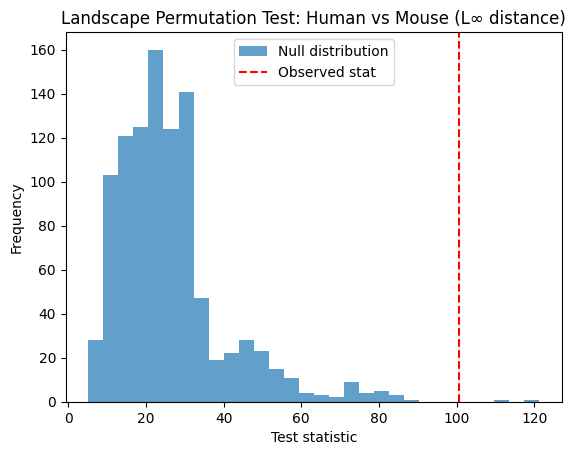

In [18]:
plt.hist(null_dist_lan, bins=30, alpha=0.7, label='Null distribution')
plt.axvline(observed_stat_lan, color='red', linestyle='--', label='Observed stat')
plt.title('Landscape Permutation Test: Human vs Mouse (L∞ distance)')
plt.xlabel('Test statistic')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/landscape_permutation_test_inter'+region+'.png')

plt.show()

## Within the groups

A permutation test *within the group* tells us what kind of differences are normal within a group that should be homogeneous.

$\to$ *Is the inter-species difference bigger than any difference we’d expect within a single species?*


### Mouse

In [19]:
mouse_stats_lan =fcts.within_group_permutation_test(landscape_mouse, n_trials=100)

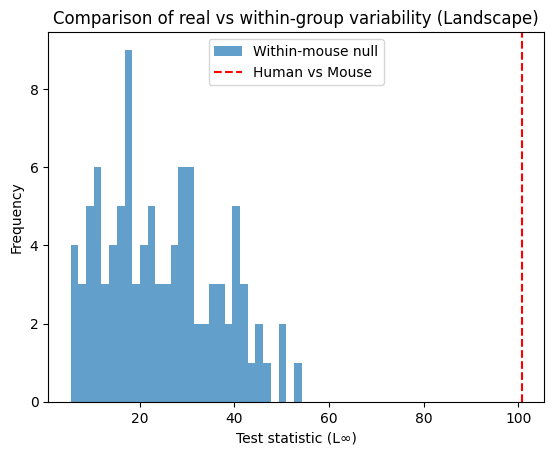

In [20]:
plt.hist(mouse_stats_lan, bins=30, alpha=0.7, label='Within-mouse null')
plt.axvline(observed_stat_lan, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Landscape)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('../Images/landscape_permutation_test_mouse'+region+'.png')

plt.show()

### Human

In [21]:
human_stats_lan =fcts.within_group_permutation_test(landscape_human, n_trials=100)

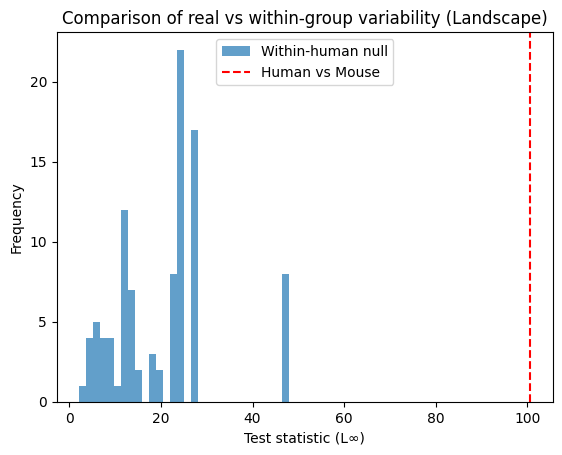

In [22]:
plt.hist(human_stats_lan, bins=30, alpha=0.7, label='Within-human null')
plt.axvline(observed_stat_lan, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Landscape)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/landscape_permutation_test_human'+region+'.png')
plt.show()

# Silhouette Permutation test

## Between the two groups

### Statistics

In [23]:
p_value_sil, observed_stat_sil, null_dist_sil = fcts.permutation_test(
    silhouettes_human,
    silhouettes_mouse,
    n_permutations=1000,
    metric='linf'  # or 'l2'
)

print(f"Observed test statistic (Silhouette): {observed_stat_sil:.4f}")
print(f"P-value (Silhouette): {p_value_sil:.4f}")

Observed test statistic (Silhouette): 58.6340
P-value (Silhouette): 0.0010


The analysis yielded an observed **test statistic of 37.7985**, and a **p-value of 0.0010**, based on 1000 permutations. This indicates that under the null hypothesis -- assuming no real difference in the topological shape distributions between groups -- such a large difference would occur in only 0.1% of random label assignments.

We therefore reject the null hypothesis and conclude that the apical dendrites of human and mouse neurons exhibit statistically significant differences in their topological structure, as captured by persistence-based descriptors.

### Plots

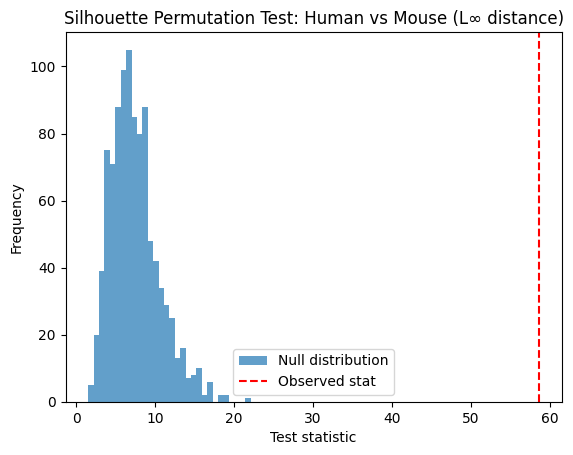

In [24]:
plt.hist(null_dist_sil, bins=30, alpha=0.7, label='Null distribution')
plt.axvline(observed_stat_sil, color='red', linestyle='--', label='Observed stat')
plt.title('Silhouette Permutation Test: Human vs Mouse (L∞ distance)')
plt.xlabel('Test statistic')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('Images/silhouette_permutation_test_inter'+region+'.png')

plt.show()

This result is further illustrated in the plot, which shows the null distribution of test statistics obtained from the 1000 permutations. The red dashed line represents the observed test statistic computed from the actual group labels. Its clear separation from the bulk of the null distribution confirms that the difference in topological signatures between human and mouse apical dendrites is not attributable to random variation. The shape of the null distribution also highlights the sensitivity of the test: values as extreme as the observed one were almost never reached under random labelings, providing strong empirical support for the statistical significance of the difference.

## Within the groups

A permutation test *within the group* tells us what kind of differences are normal within a group that should be homogeneous.

$\to$ *Is the inter-species difference bigger than any difference we’d expect within a single species?*


### Mouse

In [25]:
mouse_stats_sil =fcts.within_group_permutation_test(silhouettes_mouse, n_trials=100)

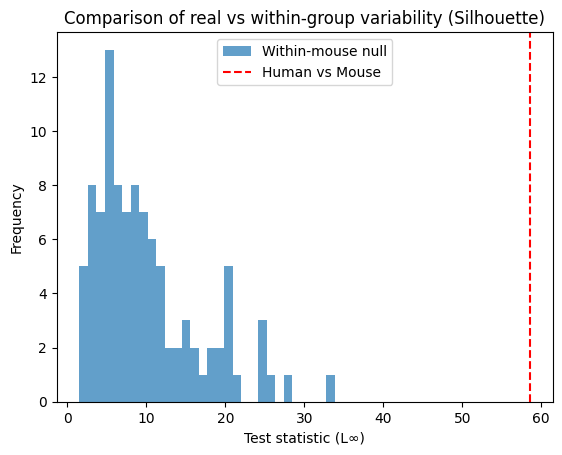

In [26]:
plt.hist(mouse_stats_sil, bins=30, alpha=0.7, label='Within-mouse null')
plt.axvline(observed_stat_sil, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Silhouette)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/silhouette_permutation_test_mouse'+region+'.png')

plt.show()

### Human

In [27]:
human_stats_sil =fcts.within_group_permutation_test(silhouettes_human, n_trials=100)

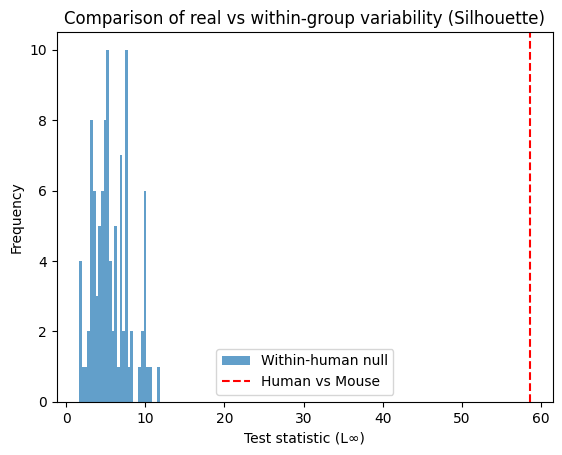

In [28]:
plt.hist(human_stats_sil, bins=30, alpha=0.7, label='Within-human null')
plt.axvline(observed_stat_sil, color='red', linestyle='--', label='Human vs Mouse')
plt.title('Comparison of real vs within-group variability (Silhouette)')
plt.xlabel('Test statistic (L∞)')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig('../Images/silhouette_permutation_test_human'+region+'.png')
plt.show()

# Summary of the three functional summaries

## Statistics

In [29]:
print(f"Entropy: Observed statistic: {observed_stat_ent:.4f}, P-value:{p_value_ent:.4f}")
print(f"Landscape: Observed statistic: {observed_stat_lan:.4f}, P-value:{p_value_lan:.4f}")
print(f"Silhouette: Observed statistic: {observed_stat_sil:.4f}, P-value:{p_value_sil:.4f}")

Entropy: Observed statistic: 1.5581, P-value:0.0010
Landscape: Observed statistic: 100.6993, P-value:0.0030
Silhouette: Observed statistic: 58.6340, P-value:0.0010


## Inter-group

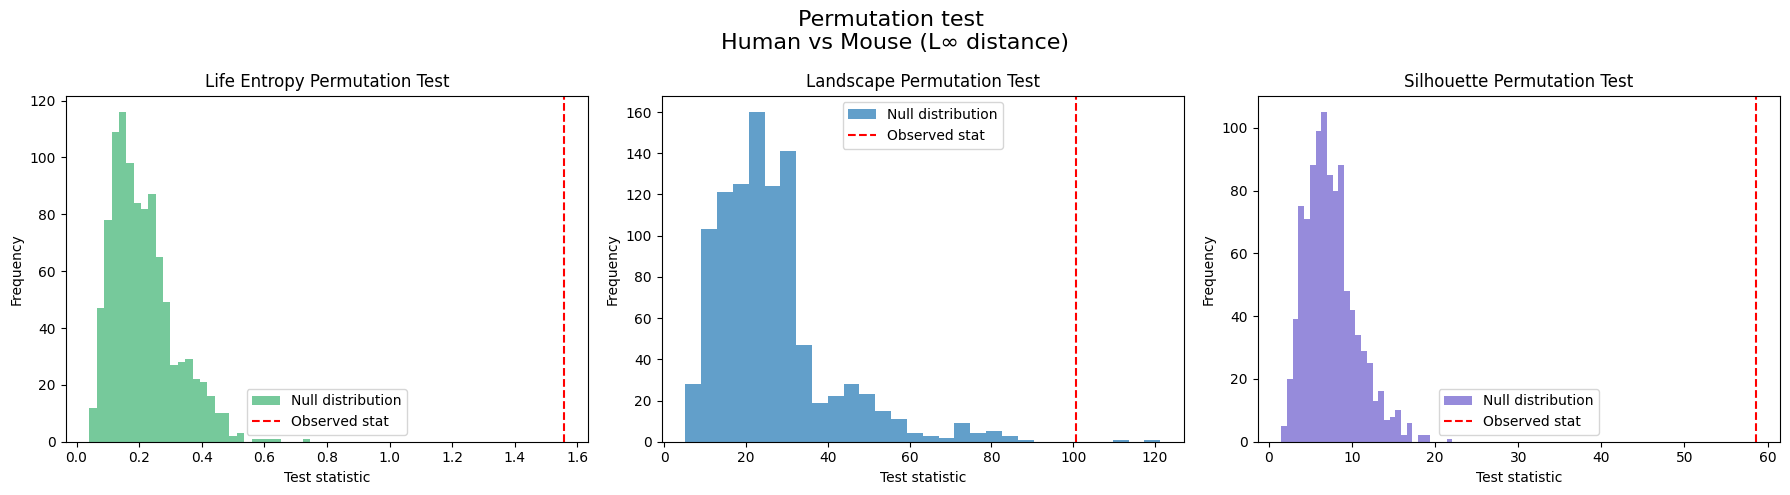

In [30]:
# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Entropy Permutation Test
axes[0].hist(null_dist_ent, color='mediumseagreen',bins=30, alpha=0.7, label='Null distribution')
axes[0].axvline(observed_stat_ent, color='red', linestyle='--', label='Observed stat')
axes[0].set_title('Life Entropy Permutation Test')
axes[0].set_xlabel('Test statistic')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot 2: Landscape Permutation Test
axes[1].hist(null_dist_lan, bins=30, alpha=0.7, label='Null distribution')
axes[1].axvline(observed_stat_lan, color='red', linestyle='--', label='Observed stat')
axes[1].set_title('Landscape Permutation Test')
axes[1].set_xlabel('Test statistic')
axes[1].set_ylabel('Frequency')
axes[1].legend()

axes[2].hist(null_dist_sil, color='slateblue', bins=30, alpha=0.7, label='Null distribution')
axes[2].axvline(observed_stat_sil, color='red', linestyle='--', label='Observed stat')
axes[2].set_title('Silhouette Permutation Test')
axes[2].set_xlabel('Test statistic')
axes[2].set_ylabel('Frequency')
axes[2].legend()

fig.suptitle("Permutation test \nHuman vs Mouse (L∞ distance)", fontsize=16)
plt.tight_layout()
#plt.savefig("../Images/permutation_summary_inter.png", dpi=300)
plt.show()

## Intra-group

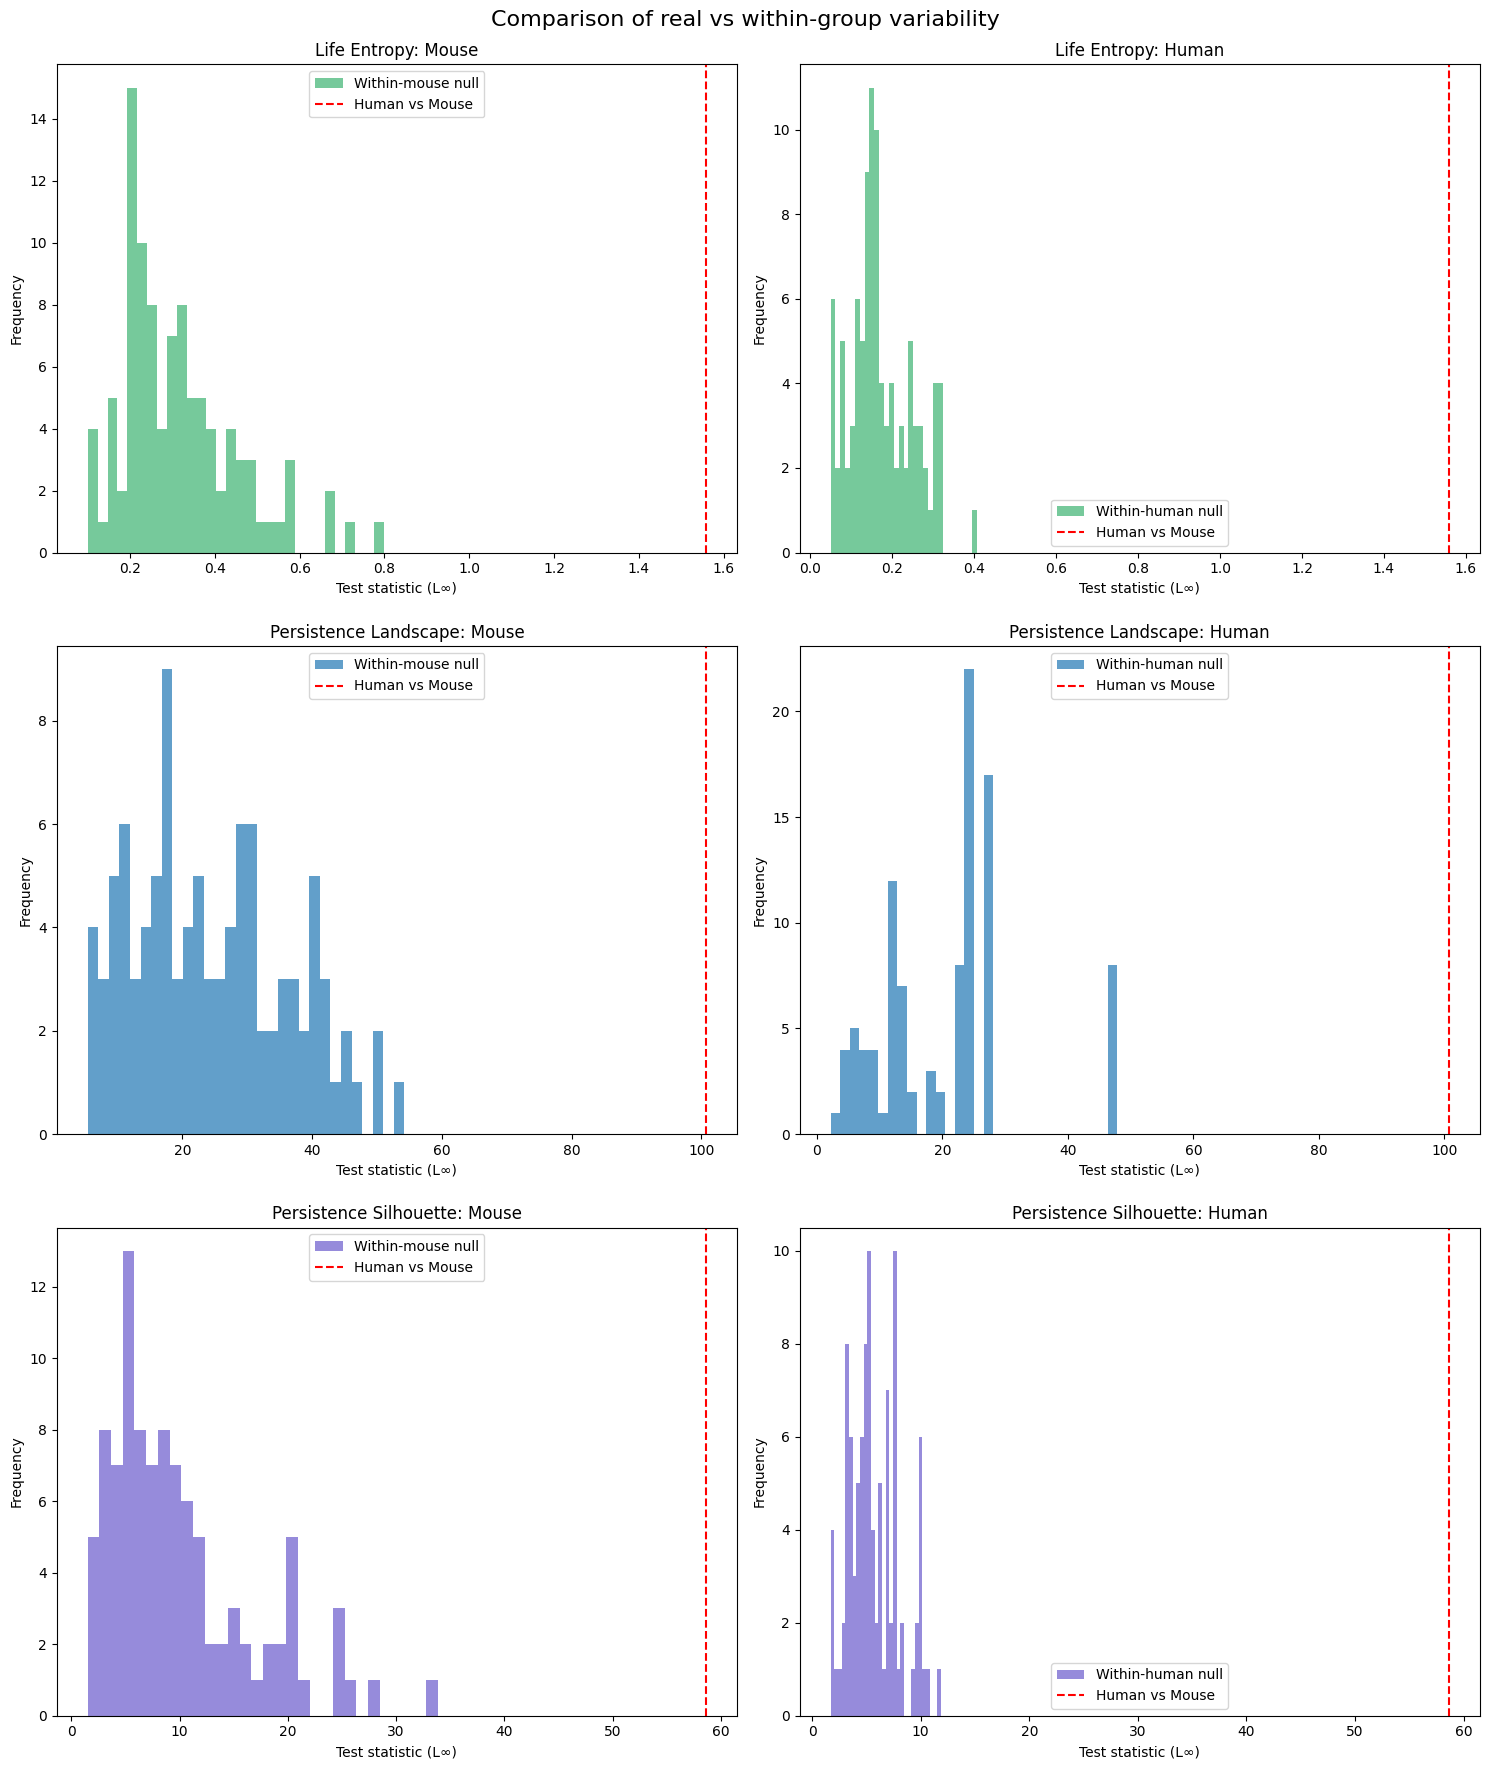

In [31]:
# Create the figure
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

#Plot for entropy

axes[0].hist(mouse_stats_ent, color='mediumseagreen',bins=30, alpha=0.7, label='Within-mouse null')
axes[0].axvline(observed_stat_ent, color='red', linestyle='--', label='Human vs Mouse')
axes[0].set_title('Life Entropy: Mouse')
axes[0].set_xlabel('Test statistic (L∞)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(human_stats_ent, color='mediumseagreen', bins=30, alpha=0.7, label='Within-human null')
axes[1].axvline(observed_stat_ent, color='red', linestyle='--', label='Human vs Mouse')
axes[1].set_title('Life Entropy: Human')
axes[1].set_xlabel('Test statistic (L∞)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

#Plot for landscape

axes[2].hist(mouse_stats_lan, bins=30, alpha=0.7, label='Within-mouse null')
axes[2].axvline(observed_stat_lan, color='red', linestyle='--', label='Human vs Mouse')
axes[2].set_title('Persistence Landscape: Mouse')
axes[2].set_xlabel('Test statistic (L∞)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

axes[3].hist(human_stats_lan, bins=30, alpha=0.7, label='Within-human null')
axes[3].axvline(observed_stat_lan, color='red', linestyle='--', label='Human vs Mouse')
axes[3].set_title('Persistence Landscape: Human')
axes[3].set_xlabel('Test statistic (L∞)')
axes[3].set_ylabel('Frequency')
axes[3].legend()

#Plot for Silhouette

axes[4].hist(mouse_stats_sil, color='slateblue', bins=30, alpha=0.7, label='Within-mouse null')
axes[4].axvline(observed_stat_sil, color='red', linestyle='--', label='Human vs Mouse')
axes[4].set_title('Persistence Silhouette: Mouse')
axes[4].set_xlabel('Test statistic (L∞)')
axes[4].set_ylabel('Frequency')
axes[4].legend()

axes[5].hist(human_stats_sil, color='slateblue', bins=30, alpha=0.7, label='Within-human null')
axes[5].axvline(observed_stat_sil, color='red', linestyle='--', label='Human vs Mouse')
axes[5].set_title('Persistence Silhouette: Human')
axes[5].set_xlabel('Test statistic (L∞)')
axes[5].set_ylabel('Frequency')
axes[5].legend()

fig.suptitle("Comparison of real vs within-group variability", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99], h_pad=2.0)  # leave space for suptitle
#plt.savefig("../Images/permutation_summary_intra.png", dpi=300)
plt.show()